# Digit Recognition using Support Vector Machines and PCA

A classic problem in the field of pattern recognition is that of handwritten digit recognition. Suppose that you have images of handwritten digits ranging from 0-9 written by various people in boxes of a specific size - similar to the application forms in banks and universities.

In [1]:
#import libraries

#EDA Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#model building and evaluation
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

### Data Understanding

In [2]:
#load datasets

digit_train = pd.read_csv('train.csv')
digit_test = pd.read_csv('test.csv')

print(f'the train dataset has {digit_train.shape[0]} rows and {digit_train.shape[1]} columns')
print()
print(f'the test dataset has {digit_test.shape[0]} rows and {digit_test.shape[1]} columns')

the train dataset has 42000 rows and 785 columns

the test dataset has 28000 rows and 784 columns


In [3]:
#what is the missing column - assumed to be label

set(digit_train.columns).difference(set(digit_test.columns))

{'label'}

In [4]:
#feature info
digit_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Data columns (total 785 columns):
 #    Column    Dtype
---   ------    -----
 0    label     int64
 1    pixel0    int64
 2    pixel1    int64
 3    pixel2    int64
 4    pixel3    int64
 5    pixel4    int64
 6    pixel5    int64
 7    pixel6    int64
 8    pixel7    int64
 9    pixel8    int64
 10   pixel9    int64
 11   pixel10   int64
 12   pixel11   int64
 13   pixel12   int64
 14   pixel13   int64
 15   pixel14   int64
 16   pixel15   int64
 17   pixel16   int64
 18   pixel17   int64
 19   pixel18   int64
 20   pixel19   int64
 21   pixel20   int64
 22   pixel21   int64
 23   pixel22   int64
 24   pixel23   int64
 25   pixel24   int64
 26   pixel25   int64
 27   pixel26   int64
 28   pixel27   int64
 29   pixel28   int64
 30   pixel29   int64
 31   pixel30   int64
 32   pixel31   int64
 33   pixel32   int64
 34   pixel33   int64
 35   pixel34   int64
 36   pixel35   int64
 37   pixel36   int64
 38   pixe

All columns are numeric in value which is to be expected. 

In [5]:
#get an idea of the null values in a dataframe
def null_dataframe(df):
    nulls = pd.DataFrame(df.isnull().mean().mul(100).sort_values(ascending=False), columns=['null_perc'])
    return nulls[nulls['null_perc']> 0]

null_dataframe(digit_train)

,null_perc


there are no null values, all the datatypes are correct. While it is not explicitly stated on Kaggle, i do believe this is a pretty clean dataset

In [6]:
sorted(digit_train['label'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

<AxesSubplot:xlabel='label', ylabel='count'>

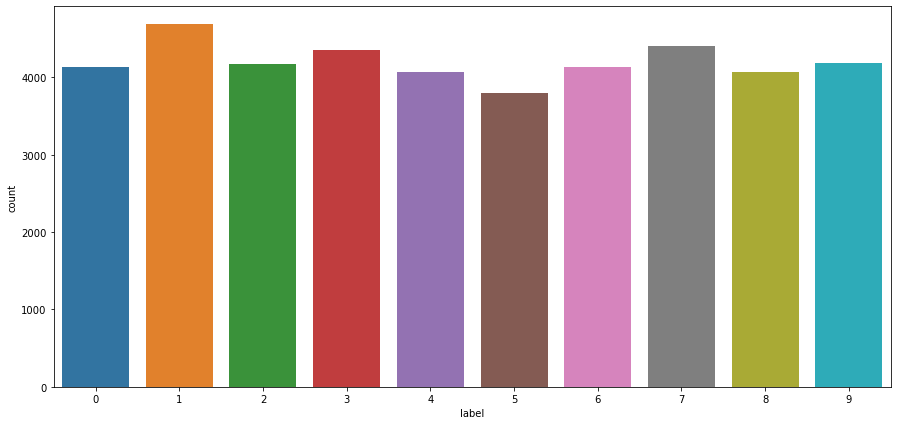

In [7]:
#get counts of each label
plt.figure(figsize=(15,7))

sns.countplot(data= digit_train, x='label')

Seems pretty well balanced with each label around 4K examples

it would be very difficult to visualise all 784 fields, since the data is balanced, there are no null values and all datatypes are expected, I will proceed to data prep



## Data Preparation

In [8]:
#splitting label from other columns
X = digit_train.drop('label', axis = 1)
y = digit_train['label']


In [9]:
#scaling object
scaler = MinMaxScaler()

#fit and transform training set
X_scaled = scaler.fit_transform(X)
columns = X.columns


#rebuild dataframes from np arrays
X_scaled = pd.DataFrame(X_scaled, columns = columns)



In [10]:
#train test split using scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, train_size = 0.7 ,random_state = 13)

## Model Building

In [11]:
#let's build a basic model first and see how the performance goes
#C=1, kernel =linear

init_model = SVC(kernel='linear')
init_model.fit(X_train, y_train)


SVC(kernel='linear')

In [12]:
#predictions on training set (probably overfit)

y_pred = init_model.predict(X_test)

# confusion matrix and accuracy

# accuracy
print("accuracy:", accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# confusion matrix
print(confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.9275396825396826 

[[1185    0    4    2    4   11    8    0    6    1]
 [   1 1380    2    6    1    2    2    6    9    1]
 [  10    6 1115   13    7    4   11   18   16    2]
 [   5    1   33 1153    1   49    2    7   29    7]
 [   3    7    9    1 1177    3    8    6    2   34]
 [  19    4   13   48   11 1051   19    1   20    3]
 [   8    5   18    2    8   17 1193    1    1    0]
 [   2    8    9    6    8    2    1 1232    5   34]
 [  13   28   14   35    8   38    7    1 1083   11]
 [   7    6    9   13   44    4    0   34    8 1118]]


Got a pretty decent accuracy let's tune the hyperparamters and go again

### Hyperparameter Tuning

In [13]:
#creating KFold object
folds = KFold(n_splits=5, shuffle=True, random_state=20)

#specifying hyperparameter ranges

params = {'kernel':['rbf','poly'],
          'gamma': [1e-1, 1e-2, 1e-3],
          'C':  [5, 10, 15, 20]}

model_cross_val = GridSearchCV(estimator=SVC(),
                              param_grid = params,
                              cv = folds,
                              scoring='accuracy',
                              verbose = 3,
                               n_jobs=-3,
                              return_train_score=True)

#tuning
model_cross_val.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=20, shuffle=True),
             estimator=SVC(), n_jobs=-3,
             param_grid={'C': [5, 10, 15, 20], 'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly']},
             return_train_score=True, scoring='accuracy', verbose=3)

In [14]:
# cv results
cv_results = pd.DataFrame(model_cross_val.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2484.022650,18.589663,253.005335,6.039739,5,0.1,rbf,"{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}",0.921769,0.923469,...,0.922922,0.001878,17,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,201.999514,1.866156,48.457410,0.378650,5,0.1,poly,"{'C': 5, 'gamma': 0.1, 'kernel': 'poly'}",0.971088,0.966497,...,0.970951,0.002929,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,217.252359,5.619681,88.836291,1.081043,5,0.01,rbf,"{'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}",0.976190,0.972619,...,0.975815,0.002296,2,0.998554,0.998512,0.998129,0.998427,0.998299,0.998384,0.000154
3,236.096384,7.962414,51.861127,0.272437,5,0.01,poly,"{'C': 5, 'gamma': 0.01, 'kernel': 'poly'}",0.971599,0.967347,...,0.970645,0.002856,12,0.996386,0.996386,0.996088,0.996471,0.995536,0.996173,0.000344
4,266.408502,11.080077,97.840057,2.774076,5,0.001,rbf,"{'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}",0.933333,0.939456,...,0.940542,0.004775,16,0.953314,0.951699,0.949530,0.951316,0.951488,0.951469,0.001203
5,2321.641322,18.005993,241.646274,22.525211,5,0.001,poly,"{'C': 5, 'gamma': 0.001, 'kernel': 'poly'}",0.540136,0.557823,...,0.545529,0.007089,24,0.541902,0.560526,0.540839,0.537693,0.558503,0.547893,0.009611
6,2497.516800,17.513895,283.782512,25.237601,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.921769,0.923469,...,0.922922,0.001878,17,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,211.462349,4.141036,51.361673,5.804802,10,0.1,poly,"{'C': 10, 'gamma': 0.1, 'kernel': 'poly'}",0.971088,0.966497,...,0.970951,0.002929,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,215.414700,6.019924,87.693455,7.488724,10,0.01,rbf,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.976361,0.972279,...,0.975849,0.002810,1,0.999660,0.999702,0.999787,0.999575,0.999575,0.999660,0.000081
9,201.316615,6.472448,49.211453,2.554187,10,0.01,poly,"{'C': 10, 'gamma': 0.01, 'kernel': 'poly'}",0.971429,0.966837,...,0.971291,0.002829,5,0.998895,0.999065,0.998809,0.998767,0.998554,0.998818,0.000167


In [15]:
#best hyperparameters

model_cross_val.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [16]:
#assign best values to variables
C_val = model_cross_val.best_params_['C']
gamma_val = model_cross_val.best_params_['gamma']
kernel_val = model_cross_val.best_params_['kernel']

#build model with best hyperparamters
model = SVC(C=C_val, gamma = gamma_val, kernel=kernel_val)

#fit model
model.fit(X_train,y_train)


#make predictions
y_pred = model.predict(X_test)

# metrics
print("accuracy",accuracy_score(y_test, y_pred), "\n")
print(confusion_matrix(y_test, y_pred), "\n")


accuracy 0.9777777777777777 

[[1212    0    1    1    1    2    1    0    2    1]
 [   0 1393    2    4    0    1    2    6    1    1]
 [   4    2 1174    8    2    0    2    5    4    1]
 [   1    0   11 1244    1   13    1    3    7    6]
 [   1    4    1    0 1231    0    4    0    1    8]
 [   3    0    2   15    4 1151   11    0    2    1]
 [   5    2    0    0    2    8 1234    0    2    0]
 [   0    6   10    1    4    0    1 1276    0    9]
 [   4    3    1    7    6    2    2    0 1210    3]
 [   4    2    3    5   10    4    0   12    8 1195]] 



##### Let's use PCA 

In [28]:
#import PCA and Pipeline

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [33]:
#define the pipeline object

p1 = Pipeline([('PCA', PCA(random_state=100)),('SVM',SVC())])


#define hyperparameters 

params = {'PCA__n_components':[0.8, 0.85,0.9,0.95], #specifying variance
         'SVM__C':[5, 10, 15, 20, 30, 50], #specifying C
         'SVM__kernel':['rbf','poly','linear'], #specifying kernel
         'SVM__gamma': [1e-1, 1e-2, 1e-3] #specifying gamma values 
         }


def optimized_model(pipeline, X_train, X_test, y_train, y_test, hp_tuning, folds, final_test_data):
    #randomisedsearch object - faster than gridsearch
    hp_tuned = RandomizedSearchCV(estimator=pipeline,
                              param_distributions= hp_tuning,
                              cv = folds,
                              scoring='accuracy',
                              n_iter = 90, # used gridsearch previous and got 900 fits so let's random check half that
                              verbose = 1,
                               n_jobs= -1,
                              return_train_score=False )
    #fit gridsearch object
    hp_tuned.fit(X_train, y_train)
    
    cv_results = pd.DataFrame(hp_tuned.cv_results_) #dataframe of results
    cv_results.to_csv('cross_val_results.csv', index=False) #send results to csv
    
    # Get the best hyperparameters and best model
    best_params = hp_tuned.best_params_
    best_model = hp_tuned.best_estimator_
    best_score = hp_tuned.best_score_
    
    #print scores and best parameters
    print('best score: ', best_score)
    print('best parameters: ',best_params)
    
    
    #fit and transform data based on best model PCA
    X_train_transformed = best_model.named_steps['PCA'].fit_transform(X_train)
    X_test_transformed = best_model.named_steps['PCA'].transform(X_test)
    
    #Supply PCA to SVC
    
    SVM_model = best_model.named_steps['SVM'].fit(X_train_transformed, y_train)
    
    #make predictions
    y_pred = SVM_model.predict(X_test_transformed)
    
    # metrics
    print("accuracy",accuracy_score(y_test, y_pred), "\n")
    
    #scaling test data
    digit_test_scaled = pd.DataFrame(scaler.transform(final_test_data), columns = final_test_data.columns )
    
    #using pca for test
    digit_test_transformed = best_model.named_steps['PCA'].transform(digit_test_scaled)
    
    #make predictions on actual test dataset
    actual_pred = SVM_model.predict(digit_test_transformed)
    
    #make new dataframe for concaten
    actual_pred = pd.DataFrame(actual_pred, columns=['Predicted_Label'])
    
    #concatenate predicted labels with test data set
    final_test = pd.concat([actual_pred,final_test_data], axis=1)
    
    #export to CSV
    final_test.to_csv('final_predictions_test_data.csv', index=False)


    

In [34]:
optimized_model(p1, X_train, X_test, y_train, y_test, params, folds, digit_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
best score:  0.9797271795263438
best parameters:  {'SVM__kernel': 'poly', 'SVM__gamma': 0.1, 'SVM__C': 20, 'PCA__n_components': 0.9}
accuracy 0.9796825396825397 



After running, we see that a 0.9 variance retention in PCA along with a C of 20, gamma of 0.1 and polynomial kernel, we get a slightly better accuracy on the test set of 98%. 

In [35]:
#import and read the first few lines of the dataframe

preds = pd.read_csv('final_predictions_test_data.csv')
preds.head(10)

,Predicted_Label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


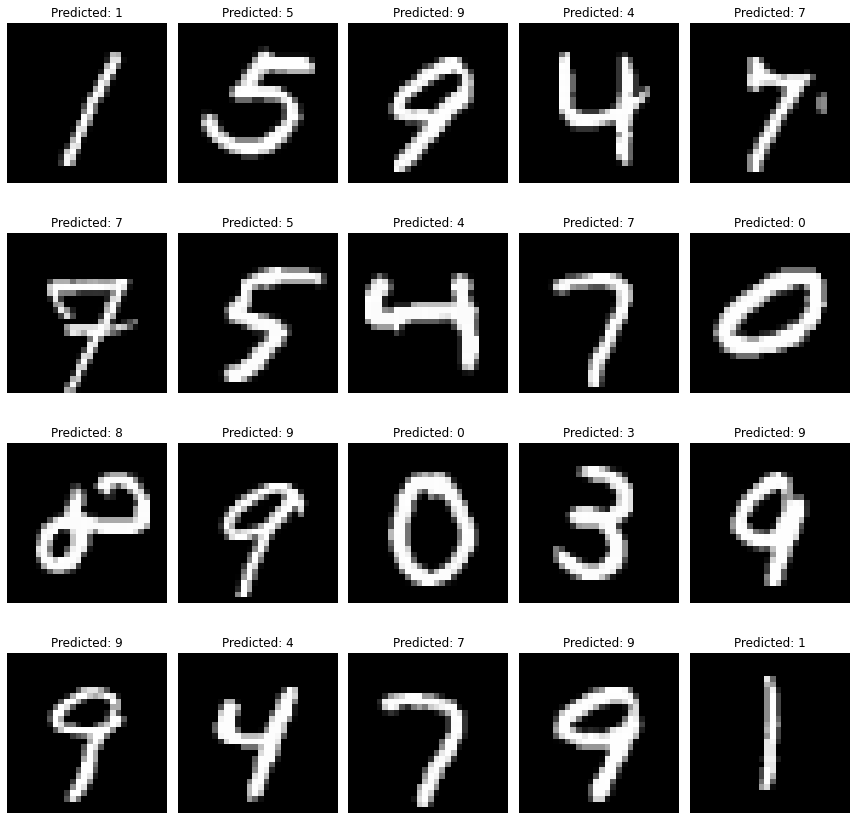

In [42]:
pixel_values = preds.iloc[:, 1:].values
predicted_labels = preds.iloc[:, 0].values

# Randomly select 5 indices
random_indices = np.random.choice(len(predicted_labels), 20, replace=False)

# Plot the randomly selected images
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12, 12))
for i, idx in enumerate(random_indices):
    # Reshape the pixel values to 28x28
    image = pixel_values[idx].reshape(28, 28)
    
    # Calculate the subplot index based on the loop index
    row = i // 5 # index 0-4 on row one
    col = i % 5 #col is the remainder 4%5 =4
    
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].set_title(f'Predicted: {predicted_labels[idx]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

20 random datapoints selected for prediction, all predicted correctly using the PCA(0.9)+SVM 

Since both SVM and PCA are linear methods, they complimented each other well. In the basic model, it is difficult to find a linear separator using linear type kernels (poly, linear) but rbf worked great. However, that required a lot of computational power to not only tune but fit. The PCA approach however allowed fewer attributes to be used with hyperparamter tuning also being completed more quickly whether it was buy a linear method line gridsearchcv or a random like randomizedsearchcv. The result is a robust model that generalised well on the unseen test dataset. Perhaps in the future I will try additional feature engineering and transformations to raise the accuracy by another few percentage points